### 1. Memuat dan periksa data

In [115]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
import numpy as np
import pickle

Load data

In [116]:
df = pd.read_csv("./ai_dev_productivity.csv")

Mengecek data

In [117]:

df

,hours_coding,coffee_intake_mg,distractions,sleep_hours,commits,bugs_reported,ai_usage_hours,cognitive_load,task_success
0,5.99,600,1,5.8,2,1,0.71,5.4,1
1,4.72,568,2,6.9,5,3,1.75,4.7,1
2,6.30,560,1,8.9,2,0,2.27,2.2,1
3,8.05,600,7,6.3,9,5,1.40,5.9,0
4,4.53,421,6,6.9,4,0,1.26,6.3,1
...,...,...,...,...,...,...,...,...,...
495,6.08,594,1,5.3,3,0,0.91,6.8,1
496,2.93,382,2,6.7,3,2,1.38,5.9,0
497,4.62,494,4,7.5,2,0,0.41,4.5,1
498,3.25,296,6,6.9,1,0,1.52,6.3,0


Mengecek missing values

In [118]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 hours_coding        0
coffee_intake_mg    0
distractions        0
sleep_hours         0
commits             0
bugs_reported       0
ai_usage_hours      0
cognitive_load      0
task_success        0
dtype: int64


### 2. Mendefinisikan fitur dan target dari data

Mendefinisikan untuk menentukan productivity score

In [119]:
df["productivity_score"] = (0.5 * df["commits"] + 0.3 * df["task_success"] - 0.2 * df["bugs_reported"])

In [120]:
X = df[["ai_usage_hours", "sleep_hours", "coffee_intake_mg", "cognitive_load", "distractions", "bugs_reported"]]
y = df["productivity_score"] 

### 3. Exploratory Data Analysis (EDA)

Mencari hubungan antara fitur dan target

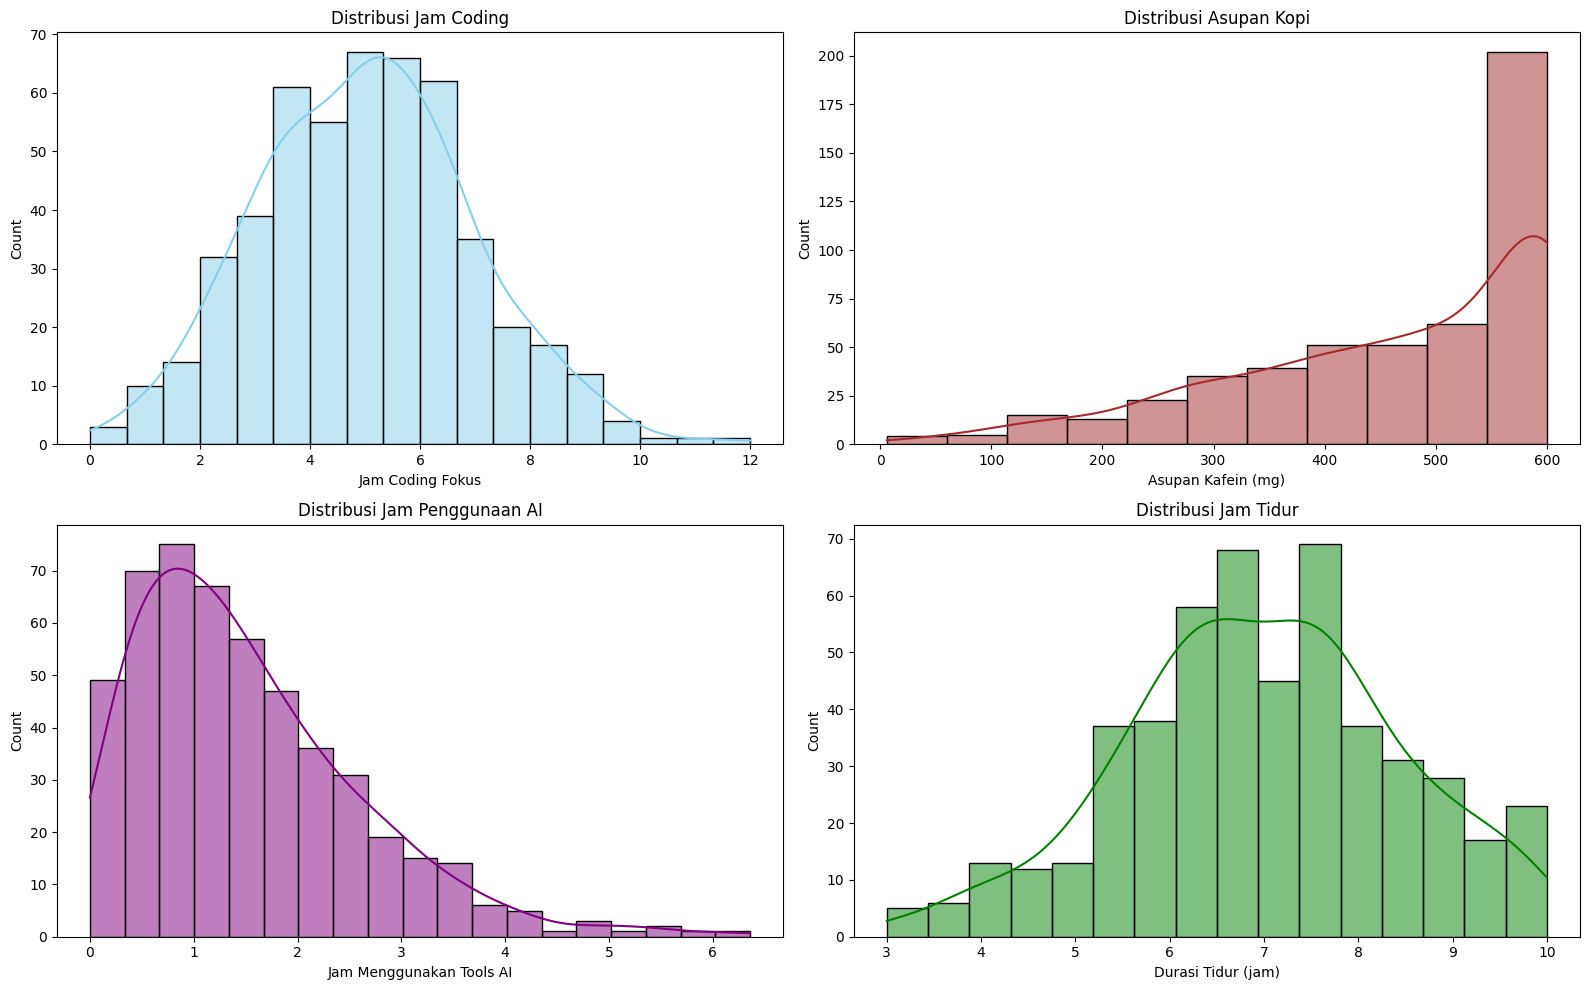

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.histplot(df['hours_coding'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribusi Jam Coding')
axes[0, 0].set_xlabel('Jam Coding Fokus')

sns.histplot(df['coffee_intake_mg'], kde=True, ax=axes[0, 1], color='brown')
axes[0, 1].set_title('Distribusi Asupan Kopi')
axes[0, 1].set_xlabel('Asupan Kafein (mg)')

sns.histplot(df['ai_usage_hours'], kde=True, ax=axes[1, 0], color='purple')
axes[1, 0].set_title('Distribusi Jam Penggunaan AI')
axes[1, 0].set_xlabel('Jam Menggunakan Tools AI')

sns.histplot(df['sleep_hours'], kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Distribusi Jam Tidur')
axes[1, 1].set_xlabel('Durasi Tidur (jam)')

plt.tight_layout()
plt.show()

Identifikasi variabel mana yang memiliki hubungan kuat dengan hasil produktivitas.

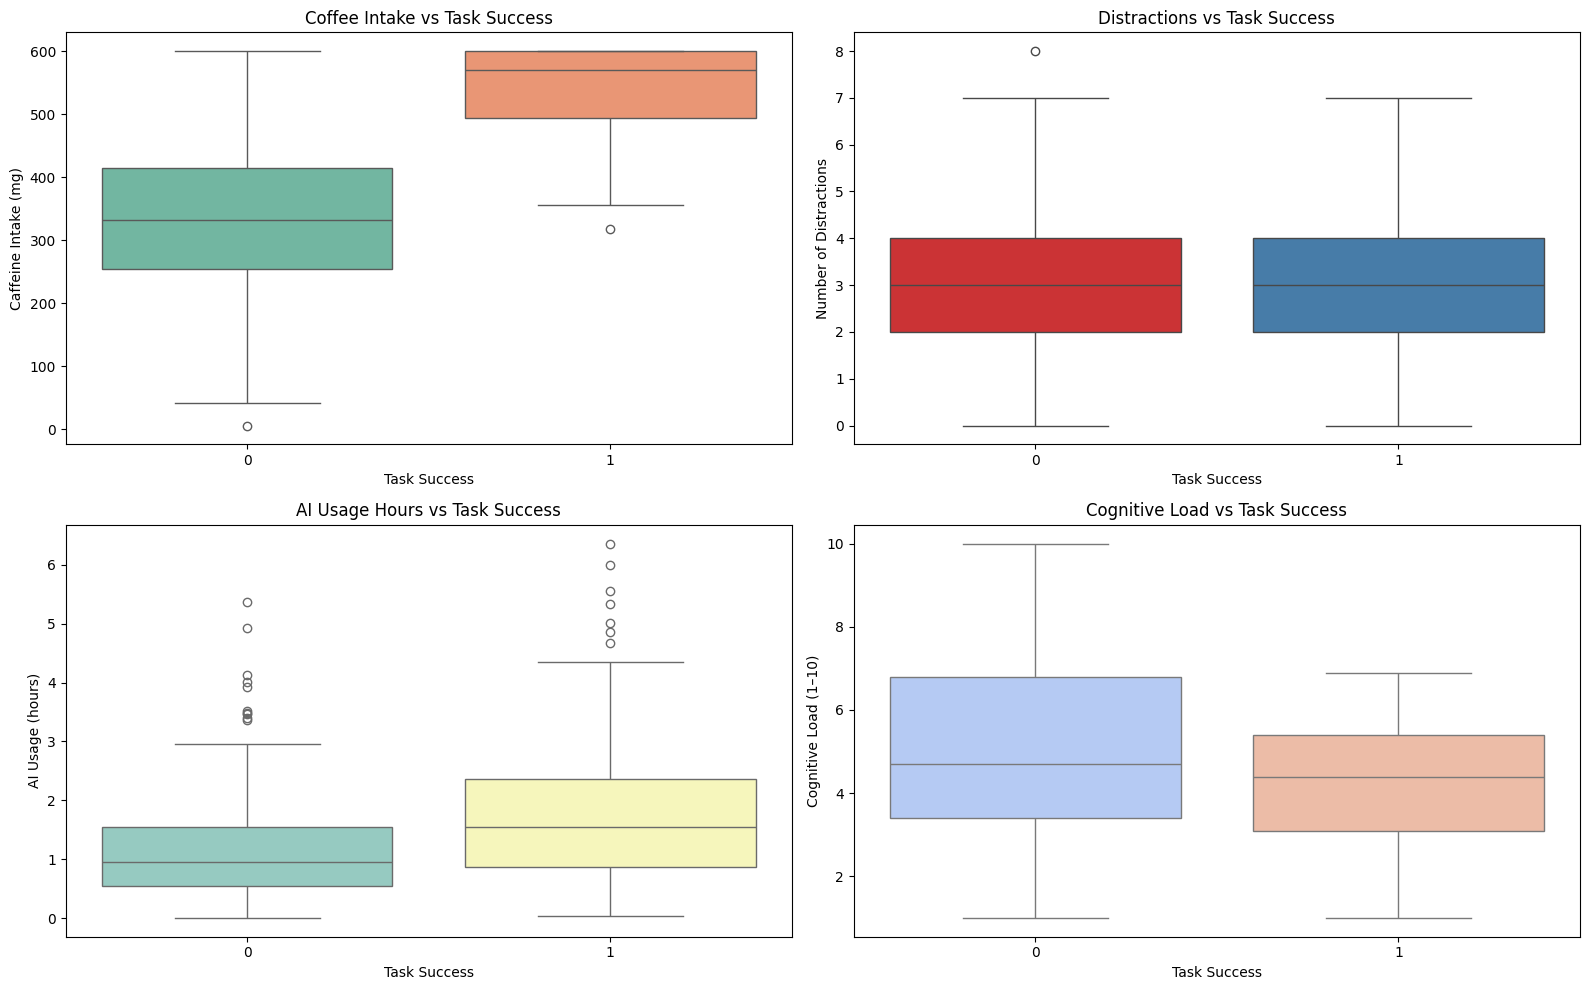

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# coffee_intake_mg vs task_success
sns.boxplot(x='task_success', y='coffee_intake_mg', data=df, ax=axes[0, 0], 
            hue='task_success', palette='Set2', legend=False)
axes[0, 0].set_title('Coffee Intake vs Task Success')
axes[0, 0].set_xlabel('Task Success')
axes[0, 0].set_ylabel('Caffeine Intake (mg)')

# distractions vs task_success
sns.boxplot(x='task_success', y='distractions', data=df, ax=axes[0, 1], 
            hue='task_success', palette='Set1', legend=False)
axes[0, 1].set_title('Distractions vs Task Success')
axes[0, 1].set_xlabel('Task Success')
axes[0, 1].set_ylabel('Number of Distractions')

# ai_usage_hours vs task_success
sns.boxplot(x='task_success', y='ai_usage_hours', data=df, ax=axes[1, 0], 
            hue='task_success', palette='Set3', legend=False)
axes[1, 0].set_title('AI Usage Hours vs Task Success')
axes[1, 0].set_xlabel('Task Success')
axes[1, 0].set_ylabel('AI Usage (hours)')

# cognitive_load vs task_success
sns.boxplot(x='task_success', y='cognitive_load', data=df, ax=axes[1, 1], 
            hue='task_success', palette='coolwarm', legend=False)
axes[1, 1].set_title('Cognitive Load vs Task Success')
axes[1, 1].set_xlabel('Task Success')
axes[1, 1].set_ylabel('Cognitive Load (1–10)')

plt.tight_layout()
plt.show()

Melihat korelasi antar variabel dengan Heatmap

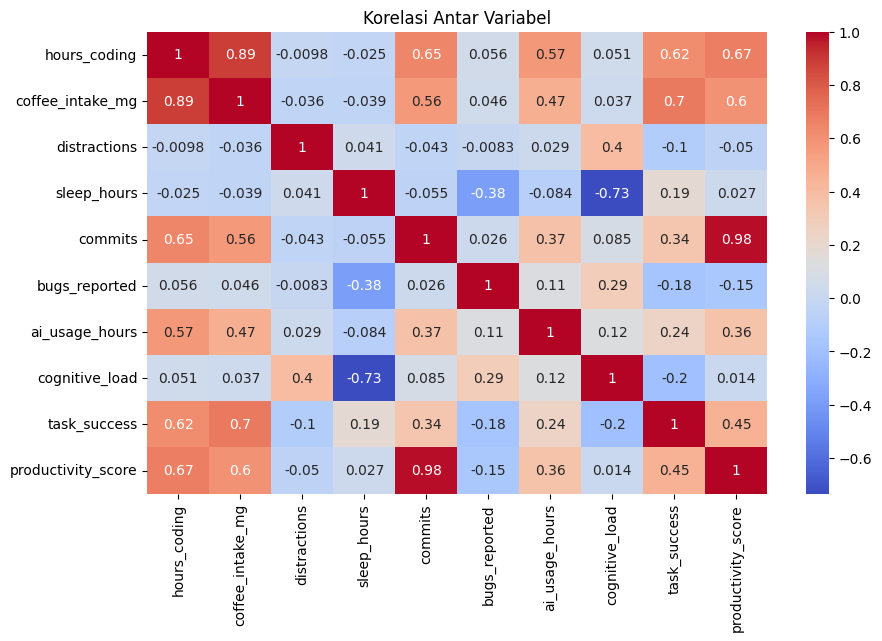

In [123]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi Antar Variabel")
plt.show()

### 4. Preprocessing Data

Mengisi missing values dengan median

In [124]:
X = X.fillna(X.median())

Menormalisasi data ke skala standar

In [125]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 5. Melatih model 

#### Regresi (Random Forest Regressor)

Menggunakan metode regresi untuk mencari tingkat produktifitas berdasarkan task success

In [126]:
df['productivity_score'] = df.apply(
    lambda row: row['commits'] / (row['hours_coding'] + 1e-6) if row['hours_coding'] != 0 
    else np.nan, axis=1
)

df = df.dropna(subset=['productivity_score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Skor R²: {r2_score(y_test, y_pred):.2f}") 

ai_users = df[df['ai_usage_hours'] > 0]['productivity_score']
print(f"\nRata-rata Produktivitas: {ai_users.mean():.2f} commit/jam")


Skor R²: 0.33

Rata-rata Produktivitas: 0.93 commit/jam


Export model regresi

In [128]:
with open('model_regressor_productivity.pkl', 'wb') as file:
    pickle.dump(model, file)

### 6. Visualisasi Data

#### 1. Akurasi Dari Model lewat Perbandingan

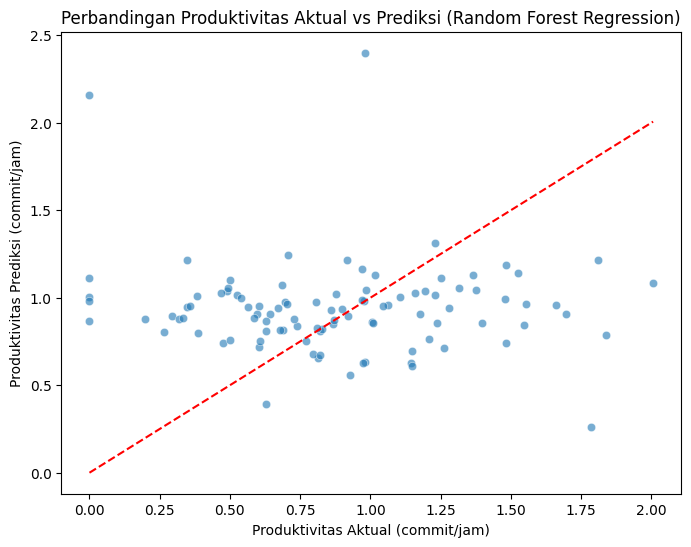

In [129]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Produktivitas Aktual (commit/jam)')
plt.ylabel('Produktivitas Prediksi (commit/jam)')
plt.title('Perbandingan Produktivitas Aktual vs Prediksi (Random Forest Regression)')
plt.show()


#### 2. Feature Importance Productivity Regresi


Pengaruh Fitur:
               Fitur  Pengaruh
0      hours_coding  0.274679
1  coffee_intake_mg  0.201393
5    cognitive_load  0.171585
6    ai_usage_hours  0.118518
3       sleep_hours  0.118179
2      distractions  0.076905
4     bugs_reported  0.038740


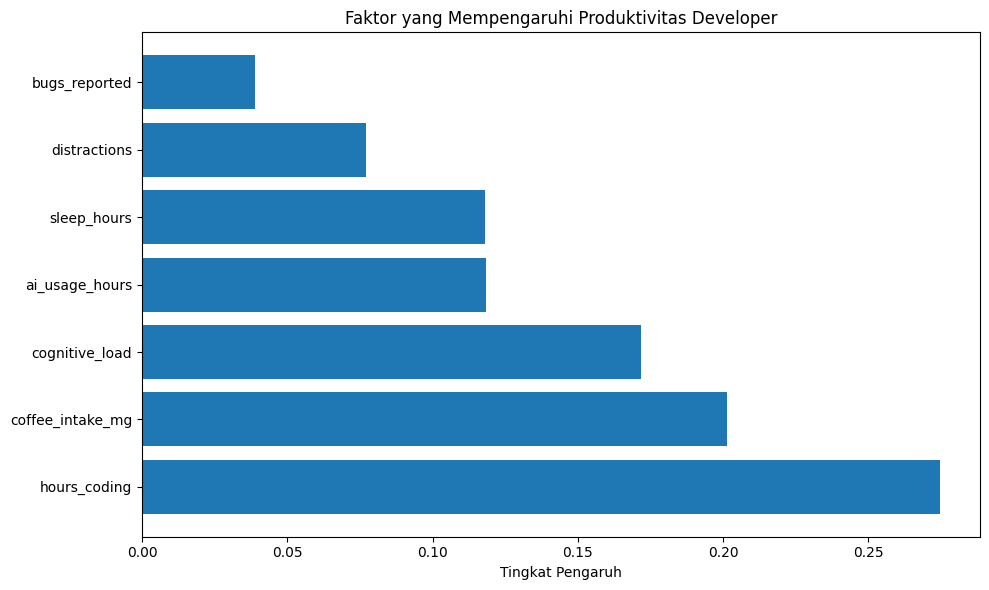

In [130]:
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Fitur': X.columns, 'Pengaruh': importances})
feature_importance = feature_importance.sort_values('Pengaruh', ascending=False)
print("\nPengaruh Fitur:\n", feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Fitur'], feature_importance['Pengaruh'])
plt.title("Faktor yang Mempengaruhi Produktivitas Developer")
plt.xlabel("Tingkat Pengaruh")
plt.tight_layout()
plt.show()

#### 3. Akurasi dari classifier

Kelas unik dalam data: [1, 2, 3]
Peringatan: Matriks memiliki 3 kelas, tetapi tersedia 4 label


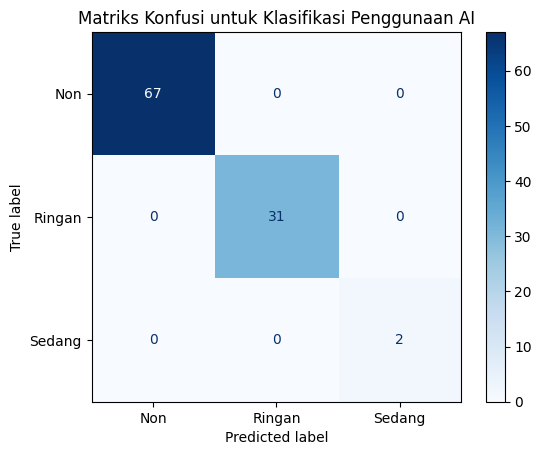

In [131]:
cm = confusion_matrix(y_test_group, y_pred_group)

unique_classes = sorted(set(y_test_group) | set(y_pred_group))
print(f"Kelas unik dalam data: {unique_classes}")

class_names = ['Non', 'Ringan', 'Sedang', 'Berat']  # Translated labels

if cm.shape[0] != len(class_names):
    print(f"Peringatan: Matriks memiliki {cm.shape[0]} kelas, tetapi tersedia {len(class_names)} label")
    class_names = class_names[:cm.shape[0]]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                            display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Matriks Konfusi untuk Klasifikasi Penggunaan AI')
plt.show()

#### 4. Feature Importance untuk classification

Kelas yang terdeteksi: [1, 2, 3]


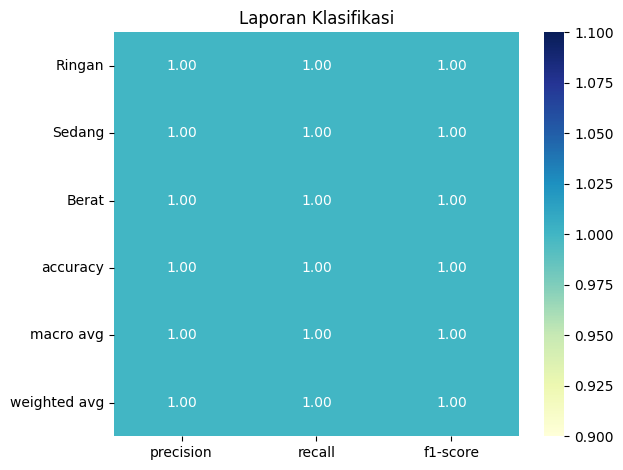

In [132]:
unique_classes = sorted(set(y_test_group) | set(y_pred_group))
print(f"Kelas yang terdeteksi: {unique_classes}")

class_mapping = {
    0: 'Non',
    1: 'Ringan',
    2: 'Sedang',
    3: 'Berat'
}
target_names = [class_mapping[cls] for cls in unique_classes]

report = classification_report(y_test_group, y_pred_group,
                             target_names=target_names,
                             output_dict=True)

report_df = pd.DataFrame(report).iloc[:-1, :].T
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Laporan Klasifikasi')
plt.tight_layout()
plt.show()

#### 5. Produktivitas vs Penggunaan AI 

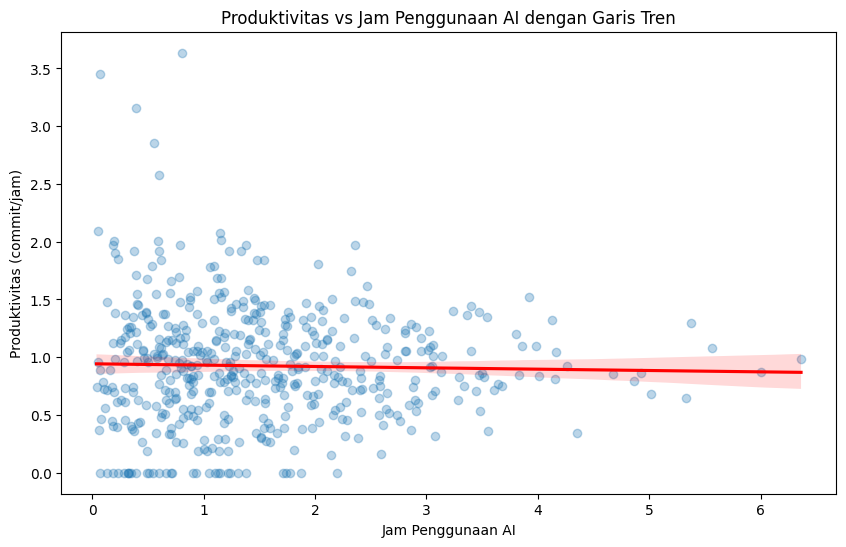

In [133]:
plt.figure(figsize=(10, 6))
sns.regplot(x='ai_usage_hours', y='productivity_score', data=df, 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.xlabel('Jam Penggunaan AI')
plt.ylabel('Produktivitas (commit/jam)')
plt.title('Produktivitas vs Jam Penggunaan AI dengan Garis Tren')
plt.show()
